In [3]:
# load datasets:

import importlib
import random
import argparse
import configparser
import numpy as np
import networkx as nx
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_sparse
from torch import Tensor
from torch.nn import Linear
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch.optim as optim

from torch_geometric.utils import negative_sampling, to_networkx
from typing import Union, Tuple
from torch_geometric.typing import OptPairTensor, Adj, OptTensor, Size
from torch_sparse import SparseTensor, matmul
from torch_geometric.nn.conv import MessagePassing

from ogb.linkproppred import PygLinkPropPredDataset, Evaluator


import networkx as nx
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

import scipy
import math


from dataset_utils import node_feature_utils
from dataset_utils.node_feature_utils import *
import my_utils as utils
import sys,os
sys.path.append(os.getcwd())


importlib.reload(utils)

Using backend: pytorch


<module 'my_utils' from '/li_zhengdao/github/GenerativeGNN/my_utils.py'>

# generate and save regression datasets:
- small: MUTAG, NCI1, DD, CIFAR10, MNIST, SYN_CC
- middle: ogbg-molhiv, ogbg-molbace, ogbg-moltox21

# TODO:
```
    'REDDIT-BINARY': RedditBinary,
    'REDDIT-MULTI-5K': Reddit5K,
    'COLLAB': Collab,
    'IMDB-BINARY': IMDBBinary,
    'IMDB-MULTI': IMDBMulti,
    'ENZYMES': Enzymes,
    'PROTEINS': Proteins,
```

In [4]:
# Load specific dataset:




from PrepareDatasets import DATASETS
import my_utils
import dataset_utils


print(DATASETS.keys())
"""
    'REDDIT-BINARY': RedditBinary,
    'REDDIT-MULTI-5K': Reddit5K,
    'COLLAB': Collab,
    'IMDB-BINARY': IMDBBinary,
    'IMDB-MULTI': IMDBMulti,
    'ENZYMES': Enzymes,
    'PROTEINS': Proteins,
    'NCI1': NCI1,
    'DD': DD,
    "MUTAG": Mutag,
    'CSL': CSL
"""

data_names = ['PROTEINS']
data_names = ['DD']
data_names = ['ENZYMES']
data_names = ['NCI1']
data_names = ['IMDB-MULTI']
data_names = ['REDDIT-BINARY']
data_names = ['CIFAR10']
data_names = ['ogbg_molhiv']

# NOTE:new kernel:
data_names = ['DD', 'PROTEINS', 'ENZYMES']

data_names = ['ogbg_moltox21','ogbg-molbace']

data_names = ['MUTAG']
data_names = []
datasets_obj = {}
for k, v in DATASETS.items():
    if k not in data_names:
        continue
    print('loaded dataset, name:', k)
    dat = v(use_node_attrs=True)
    datasets_obj[k] = dat
    # print(type(dat.dataset.get_data()))

dict_keys(['REDDIT-BINARY', 'REDDIT-MULTI-5K', 'COLLAB', 'IMDB-BINARY', 'IMDB-MULTI', 'NCI1', 'AIDS', 'ENZYMES', 'PROTEINS', 'DD', 'MUTAG', 'CSL', 'CIFAR10', 'MNIST', 'PPI', 'hiv', 'bace', 'bbpb', 'ogbg_molhiv', 'ogbg_ppa', 'PTC', 'QM9', 'ogbg_moltox21', 'ogbg-molbbbp', 'ogbg-molbace', 'syn_cc'])


In [28]:
# extract features: mean, std of: avg, pooling, cc, tri_num, cycle4_num, ..., kernel features

import dataset_utils.node_feature_utils as nfu
from scipy.stats import pearsonr

# TODO: load each fold logs to construct y:
import json

# MUTAG:
# GIN_degree_log_path: [result_GIN_0403_GIN_degree_MUTAG]
# MLP_log_path: [result_GIN_0403_GIN_degree_MUTAG]
# GIN_degree_log_path: [result_GIN_0403_GIN_degree_MUTAG]
"""
{"best_config": {"config": {"model": "GIN", "device": "cuda:1", "batch_size": 64, "learning_rate": 0.0001, "classifier_epochs": 200, "hidden_units": [64, 64, 64, 64], "layer_num": 5, "optimizer": "Adam", "scheduler": {"class": "StepLR", "args": {"step_size": 50, "gamma": 0.5}}, "loss": "MulticlassClassificationLoss", "train_eps": false, "l2": 0.0, "aggregation": "sum", "gradient_clipping": null, "dropout": 0.5, "early_stopper": {"class": "Patience", "args": {"patience": 50, "use_loss": false}}, "shuffle": true, "resume": false, "additional_features": "degree", "node_attribute": false, "shuffle_feature": false, "roc_auc": false, "mol_split": false, "dataset": "syn_cc", "config_file": "gnn_comparison/config_GIN_lzd_degree.yml", "experiment": "endtoend", "result_folder": "results/result_0422_GIN_lzd_degree_syn_cc_0.1", "dataset_name": "syn_cc", "dataset_para": "0.1", "outer_folds": 10, "outer_processes": 2, "inner_folds": 5, "inner_processes": 1, "debug": true, "ogb_evl": false}, "TR_score": 16.183574925298277, "VL_score": 21.505376272304083, "TR_roc_auc": -1, "VL_roc_auc": -1}, "OUTER_TR": 14.774557204254199, "OUTER_TS": 11.003236511378612, "OUTER_TR_ROCAUC": -1, "OUTER_TE_ROCAUC": -1}
"""

_OUTER_RESULTS_FILENAME = 'outer_results.json'

def get_test_acc(data_root_path, fold=10):
    if data_root_path is None:
        return [None for _ in range(fold)]
    
    outer_TR_scores,outer_TS_scores,outer_TR_ROCAUC,outer_TE_ROCAUC = [],[],[],[]
    for i in range(1, fold+1):
        config_filename = os.path.join(data_root_path, f'OUTER_FOLD_{i}', _OUTER_RESULTS_FILENAME)

        with open(config_filename, 'r') as fp:
            outer_fold_scores = json.load(fp)

            outer_TR_scores.append(outer_fold_scores['OUTER_TR'])
            outer_TS_scores.append(outer_fold_scores['OUTER_TS'])
            
            if 'OUTER_TR_ROCAUC' in outer_fold_scores:
                outer_TR_ROCAUC.append(outer_fold_scores['OUTER_TR_ROCAUC'])
                outer_TE_ROCAUC.append(outer_fold_scores['OUTER_TE_ROCAUC'])

    return outer_TS_scores


def extract_features(adjs, labels):
    
    def get_mean_std_corr(features, labels):
        
        mean = np.array(np.mean(features))
        std = np.array(np.std(features))
        print(np.isnan(mean).any(), np.isnan(std).any())
        x = np.array(features).reshape(-1)
        # NOTE: if multilabel, use the average of all labels:
        if len(labels[0].shape) > 1:
            corrs = []
            y = np.concatenate(labels, axis=0)
            for i in range(y.shape[1]):
                # ignore nan in y[:, i]
                not_nan = ~np.isnan(y[:, i])
                x_i = x[not_nan]
                y_i = y[not_nan]
                corr, _ = pearsonr(x_i, y_i[:, i].squeeze())
                if np.isnan(corr):
                    corr = np.array([0])
                corrs.append(corr)
            corr = np.mean(corrs)
        else:
            y = np.array(labels)
            # NOTE:
            
            not_nan = ~np.isnan(y)
            x_nn = x[not_nan]
            y_nn = y[not_nan]
            
            corr, _ = pearsonr(x_nn, y_nn)
            if np.isnan(corr):
                corr = np.array([0])
            
            if not isinstance(corr, np.ndarray):
                corr = np.array([corr])
                
        return np.array([mean.item(), std.item(), corr.item()])

    
    # F1: avgD:
    avg_d = [nfu.graph_avg_degree(adj=adj) for adj in adjs]
    f_avgD = get_mean_std_corr(avg_d, labels)
    # F2: avgCC:
    avg_cc = [nfu.node_cc_avg_feature(adj=adj) for adj in adjs]
    f_avgCC = get_mean_std_corr(avg_cc, labels)
    
    # F3: avgD/N:
    avg_DN = [nfu.graph_avgDN_feature(adj=adj) for adj in adjs]
    f_avgDN = get_mean_std_corr(avg_DN, labels)
    
    # F4: node num N:
    avg_N = [adj.shape[0] for adj in adjs]
    f_avgN = get_mean_std_corr(avg_N, labels)
    
    # F5: labels
    # calculate each dimension of labels:
    
    if len(labels[0].shape)> 1 and labels[0].shape[1] > 1:
        f_Ys = []
        Y = np.concatenate(labels, axis=0)
        for i in range(labels[0].shape[0]):
            y_i = Y[:, i]
            print('y_i: ', y_i.shape)
            y_i = y_i[~np.isnan(y_i)]
            print('y_i not nan: ', y_i.shape)
            
            f_Ys.append(get_mean_std_corr(y_i, y_i)[:2])
        f_Y = np.concatenate(f_Ys)
        f_Y = np.mean(f_Ys, axis=0)
    else:
        
        f_Y = get_mean_std_corr(labels, labels)[:2]
    
    
    # F6: cycles:
    avg_cyc = [nfu.graph_cycle_feature(adj=adj,k='4-5-6-7') for adj in adjs]
    f_cyc4 = get_mean_std_corr([c[0] for c in avg_cyc], labels)
    f_cyc5 = get_mean_std_corr([c[1] for c in avg_cyc], labels)
    f_cyc6 = get_mean_std_corr([c[2] for c in avg_cyc], labels)
    f_cyc7 = get_mean_std_corr([c[3] for c in avg_cyc], labels)
    
        
    feas = np.concatenate([f_avgD, f_avgCC, f_avgDN, f_avgN, f_Y, f_cyc4, f_cyc5, f_cyc6, f_cyc7], axis=0)
    return feas

# construct E of each fold, and plot

# Effectiveness 

def get_E(Acc_MLP_avg_degree, Acc_GNN_degree, Acc_MLP_attr, Acc_GNN_attr, is_abs=True):
    factor = 0.5
    if Acc_MLP_avg_degree is None:
        E_struct = 0
        factor = 1
    else:
        if is_abs:
            E_struct = (abs(Acc_GNN_degree - Acc_MLP_avg_degree) / Acc_MLP_avg_degree) * (100 - min(Acc_GNN_degree, Acc_MLP_avg_degree))
        else:
            E_struct = ((Acc_GNN_degree - Acc_MLP_avg_degree) / Acc_MLP_avg_degree) * (100 - min(Acc_GNN_degree, Acc_MLP_avg_degree))
    
    if Acc_MLP_attr is None:
        E_attribute = 0
        factor = 1
    else:
        if is_abs:
            E_attribute = (abs(Acc_GNN_attr - Acc_MLP_attr) / Acc_MLP_attr) * (100 - min(Acc_GNN_attr, Acc_MLP_attr))
        else:
            E_attribute = ((Acc_GNN_attr - Acc_MLP_attr) / Acc_MLP_attr) * (100 - min(Acc_GNN_attr, Acc_MLP_attr))
    return (E_struct+E_attribute) * factor

# NOTE: get E for each dataset:

def plot_E(es, ax=None, title='E=(E_struct+E_attr)/2'):
    
    # e_res = sorted(es, key=lambda x:x[0])
    e_res = es
    labels = [e[1] for e in e_res]

    if ax is None:
        fig, ax = plt.subplots(dpi=100)
        
    for e in e_res:
        bars = ax.bar(e[1], e[0], label=e[1], hatch='\\', edgecolor='black', linewidth=0.5)

    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha='center')
    ax.set_axisbelow(True)
    ax.grid(linestyle='dashed',zorder=0)
    ax.set_title(title)

# load splits as datasets:
import torch_geometric.utils as torch_utils
    
"""
the ixj th sample : (D_i_split_j, E_i_j)
"""

# Check mutag
# construct each E with each fold and
def is_pyg_dataset(d_name:str):
    return d_name.startswith('ogb') or d_name.startswith('syn')

def get_dense_adjs(dataset, dataset_name):
    adjs = []

    if is_pyg_dataset(dataset_name):
        for d in dataset:
            if d.edge_index.numel() < 1:
                N = d.x.shape[0]
                adj = np.ones(shape=(N, N))
            else:
                adj = torch_utils.to_dense_adj(d.edge_index).numpy()[0]
            adjs.append(adj)
    else:
        # NOTE: not correct, need to be fixed
        adjs = [d.to_numpy_array() for d in dataset]
        
    return adjs

def E_datasets(dataset, 
               MLP_log_path_struct=None, GNN_log_path_struct=None,
               MLP_log_path_attr=None, GNN_log_path_attr=None, fold=10):
    
    GNN_test_acc_struct = get_test_acc(GNN_log_path_struct, fold=fold)
    MLP_test_acc_struct = get_test_acc(MLP_log_path_struct, fold=fold)
    GNN_test_acc_attr = get_test_acc(GNN_log_path_attr, fold=fold)
    MLP_test_acc_attr = get_test_acc(MLP_log_path_attr, fold=fold)
    

    mutag_splits = []
    for i in range(fold):
        train_loader, val_loader = dataset.get_model_selection_fold(outer_idx=i, inner_idx=0, batch_size=1, shuffle=False)
        adjs = get_dense_adjs(train_loader.dataset, dataset.name) + get_dense_adjs(val_loader.dataset, dataset.name)
        
        labels = [d.y for d in train_loader.dataset] + [d.y for d in val_loader.dataset]
        feas = extract_features(adjs=adjs, labels=labels)
        e = get_E(MLP_test_acc_struct[i], GNN_test_acc_struct[i],  MLP_test_acc_attr[i], GNN_test_acc_attr[i])
            
        mutag_splits.append((feas, e))
        
    return mutag_splits


# save datasets
import pickle as pk

def save_datasets(datasets, file_name):
    with open(file_name, 'wb') as f:
        pk.dump(datasets, f)

def load_datasets(file_name):
    with open(file_name, 'rb') as f:
        datasets = pk.load(f)
    return datasets

In [12]:
# syn_cc datasets:


syn_cc_GNN_test_acc = []

for i in range(1, 10):
    data_root_path = f'./results/result_0506_GIN_lzd_degree_syn_cc_{i/10}/GIN_syn_cc_assessment/10_NESTED_CV'
    syn_cc_GNN_test_acc.append(get_test_acc(data_root_path, fold=10))
    

syn_cc_MLP_test_acc = []

for i in range(1, 10):
    data_root_path = f'./results/result_0506_Baseline_lzd_mlp_syn_cc_{i/10}/MolecularGraphMLP_syn_cc_assessment/10_NESTED_CV'
    syn_cc_MLP_test_acc.append(get_test_acc(data_root_path, fold=10))

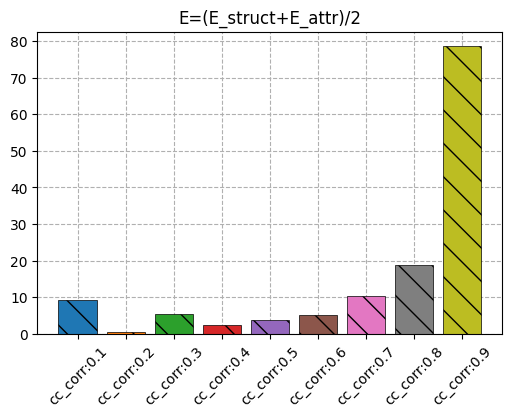

In [13]:

# plot E for each dataset:
sy_es = []
for i in range(len(syn_cc_GNN_test_acc)):
    # cc_MLP_avg_degree, Acc_GNN_degree, Acc_MLP_attr, Acc_GNN_att
    sy_es.append((get_E(np.max(syn_cc_MLP_test_acc[i]), np.max(syn_cc_GNN_test_acc[i]),
                       None, None), f'cc_corr:{(i+1)/10}'))
plot_E(sy_es)

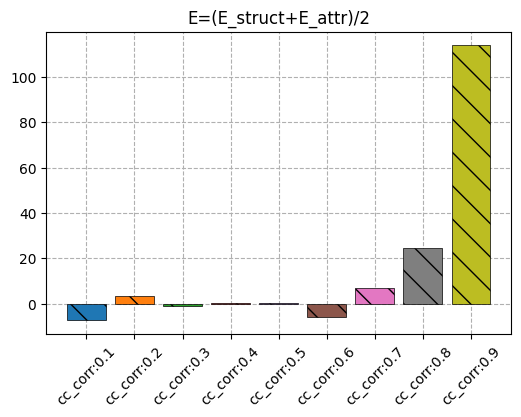

In [14]:

# plot E for each dataset:
sy_es = []
for i in range(len(syn_cc_GNN_test_acc)):
    # cc_MLP_avg_degree, Acc_GNN_degree, Acc_MLP_attr, Acc_GNN_att
    sy_es.append((get_E(np.mean(syn_cc_MLP_test_acc[i]), np.mean(syn_cc_GNN_test_acc[i]),
                       None, None, is_abs=False), f'cc_corr:{(i+1)/10}'))
plot_E(sy_es)

# visualiza E, tris, avg_degree and correlation

In [6]:
# SynCC
data_names = ['syn_cc']

syn_datasets = []
for i in range(1, 10):
    v = DATASETS['syn_cc']
    config = {'dataset_para':f'{i/10}'}
    dat = v(use_node_attrs=True, config=config)
    adjs = get_dense_adjs(dat.dataset, dat.name)
    feas = extract_features(adjs=adjs, labels=dat.dataset.get_targets())
    syn_datasets.append((feas[:], f'cc_corr:{(i+1)/10}'))
    

processed_dir:  DATA/syn_cc/processed
load dataset !
SynDataset load data_path: DATA/syn_cc_0.1.pkl
!!!! _dim_target:  10
dataset len:  4096
load splits: DATA/syn_cc/processed/syn_cc_splits.json
split counts: 10
processed_dir:  DATA/syn_cc/processed
load dataset !
SynDataset load data_path: DATA/syn_cc_0.2.pkl
!!!! _dim_target:  10
dataset len:  4096
load splits: DATA/syn_cc/processed/syn_cc_splits.json
split counts: 10
processed_dir:  DATA/syn_cc/processed
load dataset !
SynDataset load data_path: DATA/syn_cc_0.3.pkl
!!!! _dim_target:  10
dataset len:  4096
load splits: DATA/syn_cc/processed/syn_cc_splits.json
split counts: 10
processed_dir:  DATA/syn_cc/processed
load dataset !
SynDataset load data_path: DATA/syn_cc_0.4.pkl
!!!! _dim_target:  10
dataset len:  4096
load splits: DATA/syn_cc/processed/syn_cc_splits.json
split counts: 10
processed_dir:  DATA/syn_cc/processed
load dataset !
SynDataset load data_path: DATA/syn_cc_0.5.pkl
!!!! _dim_target:  10
dataset len:  4096
load splits

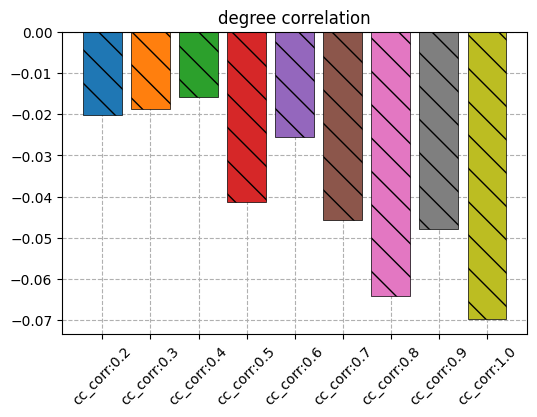

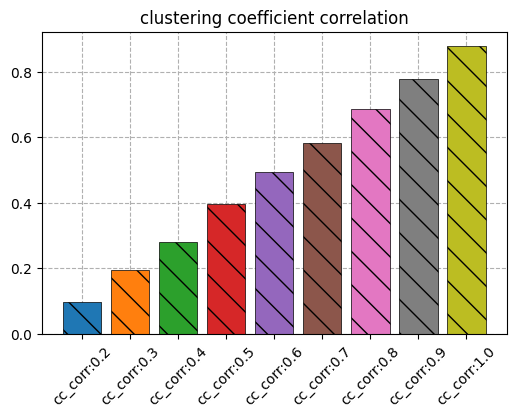

In [7]:
# dataset size = 4096

# F1: avgD:
# F2: avgCC:
# F3: avgD/N:
# F4: node num N:
# F5: labels

es_avgD = [(f[0][2], f[1]) for f in syn_datasets]
plot_E(es_avgD, title='degree correlation')

# es_avgD = [(f[0][2], f[1]) for f in syn_datasets]
# plot_E(es_avgD)

# es_CC_Corr = [(f[0][5], f[1]) for f in syn_datasets]
# plot_E(es_CC_Corr)

es_CC_Corr = [(f[0][5], f[1]) for f in syn_datasets]
plot_E(es_CC_Corr, title='clustering coefficient correlation')

In [8]:
test_cc = load_datasets('DATA/syn_test_cc.pkl')

test_syn_datasets = []
adjs = []
Y = [g.y for g in test_cc]
for d in test_cc:
    if d.edge_index.numel() < 1:
        N = d.x.shape[0]
        adj = np.ones(shape=(N, N))
    else:
        adj = torch_utils.to_dense_adj(d.edge_index).numpy()[0]
    adjs.append(adj)

feas = extract_features(adjs=adjs, labels=Y)

test_syn_datasets.append((feas[:], f'cc_corr:{(i+1)/10}'))

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


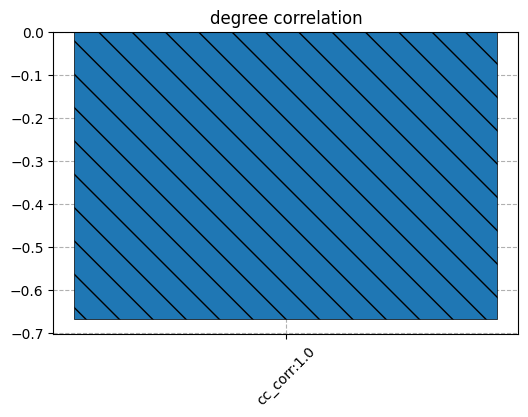

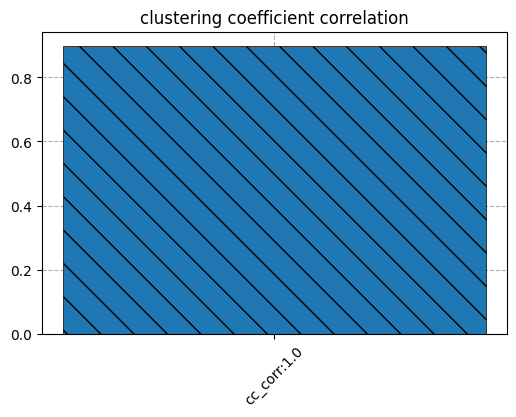

In [10]:
# dataset size = 4096

# F1: avgD:
# F2: avgCC:
# F3: avgD/N:
# F4: node num N:
# F5: labels

es_avgD = [(f[0][2], f[1]) for f in test_syn_datasets]
plot_E(es_avgD, title='degree correlation')

# es_avgD = [(f[0][2], f[1]) for f in syn_datasets]
# plot_E(es_avgD)

# es_CC_Corr = [(f[0][5], f[1]) for f in syn_datasets]
# plot_E(es_CC_Corr)

es_CC_Corr = [(f[0][5], f[1]) for f in test_syn_datasets]
plot_E(es_CC_Corr, title='clustering coefficient correlation')

0.08504691820170904
0.24820372836836402
0.8706900940728131
9


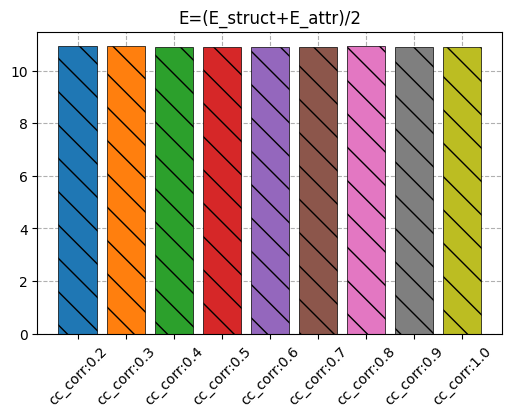

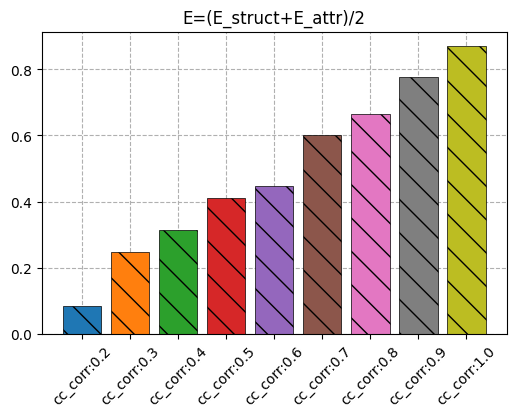

In [35]:
# dataset size = 1024

es_avgD = [(f[0][0], f[1]) for f in syn_datasets]
plot_E(es_avgD)
es_CC_Corr = [(f[0][5], f[1]) for f in syn_datasets]
plot_E(es_CC_Corr)

# MUTAG

In [ ]:
# MUTAG
del datasets_obj

# DD:

data_names = ['MUTAG']
              
datasets_obj = {}
for k, v in DATASETS.items():
    if k not in data_names:
        continue
    print('loaded dataset, name:', k)
    dat = v(use_node_attrs=True)
    datasets_obj[k] = dat
    # print(type(dat.dataset.get_data()))

GNN_attr_log_path = f'./results/result_GIN_0404_GIN_attr_MUTAG/GIN_MUTAG_assessment/10_NESTED_CV'
MLP_attr_log_path = f'./results/result_GIN_0327_finger_mlp_attr_multicrossen_MUTAG/MolecularFingerprint_MUTAG_assessment/10_NESTED_CV'
dataset = datasets_obj['MUTAG']
mutag_datasets = E_datasets(dataset, MLP_attr_log_path, GNN_attr_log_path, None, None)

save_datasets(mutag_datasets, 'mutag_datasets.pkl')


# DD

In [ ]:
# DD
"""
result_GIN_0308_DD_degree_attribute
result_GIN_0309_DD_both_degree_attribute
result_GIN_0310_DD_mix
result_GIN_0311_DD_mix
result_GIN_0312_DD_mix
result_GIN_0318_decouple_attr_degree_DD
result_GIN_0319_new_alpha_decouple_attr_degree_DD
result_GIN_0327_finger_mlp_attr_crossen_DD
result_GIN_0327_finger_mlp_attr_multicrossen_DD
"""

del datasets_obj

# DD:

data_names = ['DD']
              
datasets_obj = {}
for k, v in DATASETS.items():
    if k not in data_names:
        continue
    print('loaded dataset, name:', k)
    dat = v(use_node_attrs=True)
    datasets_obj[k] = dat
    # print(type(dat.dataset.get_data()))

GNN_attr_log_path = f'./results/result_GIN_0308_DD_degree_attribute/Adapter_DD_assessment/10_NESTED_CV'
MLP_attr_log_path = f'./results/result_GIN_0327_finger_mlp_attr_multicrossen_DD/MolecularFingerprint_DD_assessment/10_NESTED_CV'
dataset = datasets_obj['DD']
dd_datasets = E_datasets(dataset, None, None, GNN_attr_log_path, MLP_attr_log_path)

save_datasets(dd_datasets, 'dd_datasets.pkl')

# CIFAR10

In [ ]:
# CIFAR10 only has on fold
"""
result_GIN_0317_decouple_degree_attr_CIFAR10
result_GIN_0317_mix_degree_attr_CIFAR10
result_GIN_0317_only_attr_CIFAR10
result_GIN_0317_only_degree_CIFAR10
result_GIN_0318_decouple_degree_attr_CIFAR10
result_GIN_0327_finger_mlp_attr_multicrossen_CIFAR10
result_GIN_0401_GIN_degree_CIFAR10
result_GIN_0403_GIN_degree_CIFAR10
"""

del datasets_obj

# DD:

data_names = ['CIFAR10']
              
datasets_obj = {}
for k, v in DATASETS.items():
    if k not in data_names:
        continue
    print('loaded dataset, name:', k)
    dat = v(use_node_attrs=True)
    datasets_obj[k] = dat
    # print(type(dat.dataset.get_data()))
    
MLP_log_path_degree = f'./results/result_GIN_0401_graph_mlp_avgDegree_CIFAR10/MolecularGraphMLP_CIFAR10_assessment/1_NESTED_CV'
GNN_log_path_degree = f'./results/result_GIN_0317_only_degree_CIFAR10/GIN_CIFAR10_assessment/1_NESTED_CV'

MLP_log_path_attr = f'./results/result_GIN_0327_finger_mlp_attr_multicrossen_CIFAR10/MolecularFingerprint_CIFAR10_assessment/10_NESTED_CV'
GNN_log_path_attr = f'./results/result_GIN_0317_only_attr_CIFAR10/GIN_CIFAR10_assessment/1_NESTED_CV'

dataset = datasets_obj['CIFAR10']
cifar10_datasets = E_datasets(dataset, MLP_log_path_degree, GNN_log_path_degree, MLP_log_path_attr, GNN_log_path_attr, fold=1)



# MNIST

In [ ]:
# MNIST only has on fold
"""

"""

del datasets_obj

# DD:

data_names = ['MNIST']
              
datasets_obj = {}
for k, v in DATASETS.items():
    if k not in data_names:
        continue
    print('loaded dataset, name:', k)
    dat = v(use_node_attrs=True)
    datasets_obj[k] = dat
    # print(type(dat.dataset.get_data()))
    
MLP_log_path_degree = f'./results/result_GIN_0329_graph_mlp_avgDegree_MNIST/MolecularGraphMLP_MNIST_assessment/1_NESTED_CV'
GNN_log_path_degree = f'./results/result_GIN_0329_GIN_degree_MNIST/GIN_MNIST_assessment/10_NESTED_CV'

MLP_log_path_attr = f'./results/result_GIN_0425_config_fingerprint_attr.yml_MNIST/MolecularFingerprint_MNIST_assessment/10_NESTED_CV'
GNN_log_path_attr = f'./results/result_GIN_0329_GIN_attr_MNIST/GIN_MNIST_assessment/10_NESTED_CV'

dataset = datasets_obj['MNIST']
minst_datasets = E_datasets(dataset, MLP_log_path_degree, GNN_log_path_degree, MLP_log_path_attr, GNN_log_path_attr, fold=1)

save_datasets(minst_datasets, 'mnist_datasets.pkl')



# NCI1

In [ ]:
# get NCI1

# 'NCI1', 'IMDB-MULTI', 'REDDIT-BINARY', 'CIFAR10',
# #               'ogbg_molhiv', 'ogbg_moltox21', 'ogbg-molbace', 'MUTAG']


del datasets_obj

data_names = ['NCI1']
              
datasets_obj = {}
for k, v in DATASETS.items():
    if k not in data_names:
        continue
    print('loaded dataset, name:', k)
    dat = v(use_node_attrs=True)
    datasets_obj[k] = dat

MLP_log_path_degree = f'./results/result_0423_Baseline_lzd_mlp_NCI1/MolecularGraphMLP_NCI1_assessment/10_NESTED_CV'
GNN_log_path_degree = f'./results/result_GIN_0403_GIN_degree_NCI1/GIN_NCI1_assessment/10_NESTED_CV'

MLP_log_path_attr = f'./results/result_GIN_0327_finger_mlp_attr_multicrossen_NCI1/MolecularFingerprint_NCI1_assessment/10_NESTED_CV'
GNN_log_path_attr = f'./results/result_GIN_0404_GIN_attr_NCI1/GIN_NCI1_assessment/10_NESTED_CV'

dataset = datasets_obj['NCI1']
nci1_datasets = E_datasets(dataset, MLP_log_path_degree, GNN_log_path_degree,
                           MLP_log_path_attr, GNN_log_path_attr, fold=10)

save_datasets(nci1_datasets, 'nci1_datasets.pkl')



```
    'REDDIT-BINARY': RedditBinary,
    'REDDIT-MULTI-5K': Reddit5K,
    'COLLAB': Collab,
    'IMDB-BINARY': IMDBBinary,
    'IMDB-MULTI': IMDBMulti,
    'ENZYMES': Enzymes,
    'PROTEINS': Proteins,
```

In [ ]:
# get NCI1

# 'NCI1', 'IMDB-MULTI', 'REDDIT-BINARY', 'CIFAR10',
# #               'ogbg_molhiv', 'ogbg_moltox21', 'ogbg-molbace', 'MUTAG']


del datasets_obj

data_names = ['IMDB-BINARY']
              
datasets_obj = {}
for k, v in DATASETS.items():
    if k not in data_names:
        continue
    print('loaded dataset, name:', k)
    dat = v(use_node_attrs=True)
    datasets_obj[k] = dat

MLP_log_path_degree = f'./results/result_0424_Baseline_lzd_mlp_IMDB-BINARY/MolecularGraphMLP_IMDB-BINARY_assessment/10_NESTED_CV'
GNN_log_path_degree = f'./results/result_GIN_0226_load_degree_norm/GIN_IMDB-BINARY_assessment/10_NESTED_CV'

# MLP_log_path_attr = f'./results/result_GIN_0327_finger_mlp_attr_multicrossen_NCI1/MolecularFingerprint_NCI1_assessment/10_NESTED_CV'
# GNN_log_path_attr = f'./results/result_GIN_0404_GIN_attr_NCI1/GIN_NCI1_assessment/10_NESTED_CV'


dataset = datasets_obj['IMDB-BINARY']
imdb_b_datasets = E_datasets(dataset, MLP_log_path_degree, GNN_log_path_degree, fold=10)

save_datasets(imdb_b_datasets, 'imdb_b_datasets.pkl')




In [ ]:
# get NCI1

# 'NCI1', 'IMDB-MULTI', 'REDDIT-BINARY', 'CIFAR10',
# #               'ogbg_molhiv', 'ogbg_moltox21', 'ogbg-molbace', 'MUTAG']


del datasets_obj

data_names = ['IMDB-MULTI']
              
datasets_obj = {}
for k, v in DATASETS.items():
    if k not in data_names:
        continue
    print('loaded dataset, name:', k)
    dat = v(use_node_attrs=True)
    datasets_obj[k] = dat

MLP_log_path_degree = f'./results/result_0424_Baseline_lzd_mlp_IMDB-MULTI/MolecularGraphMLP_IMDB-MULTI_assessment/10_NESTED_CV'
GNN_log_path_degree = f'./results/result_GIN_0313_only_degree_IMDB-MULTI/GIN_IMDB-MULTI_assessment/10_NESTED_CV'

# MLP_log_path_attr = f'./results/result_GIN_0327_finger_mlp_attr_multicrossen_NCI1/MolecularFingerprint_NCI1_assessment/10_NESTED_CV'
# GNN_log_path_attr = f'./results/result_GIN_0404_GIN_attr_NCI1/GIN_NCI1_assessment/10_NESTED_CV'


dataset = datasets_obj['IMDB-MULTI']
imdb_m_datasets = E_datasets(dataset, MLP_log_path_degree, GNN_log_path_degree, fold=10)

save_datasets(imdb_m_datasets, 'imdb_m_datasets.pkl')




# ogbg_molhiv

In [4]:
# get NCI1

# 'NCI1', 'IMDB-MULTI', 'REDDIT-BINARY', 'CIFAR10',
# #               'ogbg_molhiv', 'ogbg_moltox21', 'ogbg-molbace', 'MUTAG']

del datasets_obj

data_names = ['ogbg_molhiv']
              
datasets_obj = {}
for k, v in DATASETS.items():
    if k not in data_names:
        continue
    print('loaded dataset, name:', k)
    dat = v(use_node_attrs=True)
    datasets_obj[k] = dat

MLP_log_path_degree = f'./results/result_GIN_0329_graph_mlp_avgDegree_ogbg_molhiv/MolecularGraphMLP_ogbg_molhiv_assessment/1_NESTED_CV'
GNN_log_path_degree = f'./results/result_0323_GIN_only_degreeogbg_molhiv/GIN_ogbg_molhiv_assessment/10_NESTED_CV'

MLP_log_path_attr = f'./results/result_GIN_0326_mlp_single_attr_ogbg_molhiv/MolecularFingerprint_ogbg_molhiv_assessment/1_NESTED_CV'
GNN_log_path_attr = f'./results/result_GIN_0323_EGNN_only_attr_ogbg_molhiv/EGIN_ogbg_molhiv_assessment/1_NESTED_CV'

dataset = datasets_obj['ogbg_molhiv']
ogbg_molhiv_datasets = E_datasets(dataset, MLP_log_path_degree, GNN_log_path_degree, MLP_log_path_attr, GNN_log_path_attr, fold=1)

loaded dataset, name: ogbg_molhiv
processed_dir:  DATA/ogbg-molhiv/processed
load dataset !
ogbg _dim_target: 2
!!!! _dim_target:  2
dataset len:  41127


In [5]:
# save ogbg_molhiv_datasets
save_datasets(ogbg_molhiv_datasets, 'ogbg_molhiv_datasets.pkl')

# ogbg_moltox21

In [29]:
# get NCI1

# 'NCI1', 'IMDB-MULTI', 'REDDIT-BINARY', 'CIFAR10',
# #               'ogbg_molhiv', 'ogbg_moltox21', 'ogbg-molbace', 'MUTAG']


data_names = ['ogbg_moltox21']
              
datasets_obj = {}
for k, v in DATASETS.items():
    if k not in data_names:
        continue
    print('loaded dataset, name:', k)
    dat = v(use_node_attrs=True)
    datasets_obj[k] = dat


MLP_log_path_degree = f'./results/result_0424_Baseline_lzd_mlp_mol_ogbg_moltox21/MolecularGraphMLP_ogbg_moltox21_assessment/1_NESTED_CV'
GNN_log_path_degree = f'./results/result_GIN_0410_GIN_lzd_degree_ogbg_moltox21/GIN_ogbg_moltox21_assessment/1_NESTED_CV'

MLP_log_path_attr = f'./results/result_GIN_0411_atomencoder_attr_ogbg_moltox21/AtomMLP_ogbg_moltox21_assessment/1_NESTED_CV'
GNN_log_path_attr = f'./results/result_GIN_0409_EGNN_lzd_attr_ogbg_moltox21/EGNN_ogbg_moltox21_assessment/1_NESTED_CV'

dataset = datasets_obj['ogbg_moltox21']
ogbg_moltox21_datasets = E_datasets(dataset, MLP_log_path_degree, GNN_log_path_degree, MLP_log_path_attr, GNN_log_path_attr, fold=1)



loaded dataset, name: ogbg_moltox21
processed_dir:  DATA/ogbg-moltox21/processed
load dataset !
self.name: ogbg-moltox21
False
ogbg _dim_target: 12
!!!! _dim_target:  12
dataset len:  7831
False False
False False
False False
False False
y_i:  (7047,)
y_i not nan:  (6556,)
False False
False False
False False
False False
False False


In [ ]:
print(dataset.dataset.num_classes)
print(dataset.dataset.num_tasks)

2
12


In [30]:
save_datasets(ogbg_moltox21_datasets, 'ogbg_moltox21_datasets.pkl')

# ogbg-molbace

In [ ]:
# get NCI1

# 'NCI1', 'IMDB-MULTI', 'REDDIT-BINARY', 'CIFAR10',
# #               'ogbg_molhiv', 'ogbg_moltox21', 'ogbg-molbace', 'MUTAG']


data_names = ['ogbg-molbace']
              
datasets_obj = {}
for k, v in DATASETS.items():
    if k not in data_names:
        continue
    print('loaded dataset, name:', k)
    dat = v(use_node_attrs=True)
    datasets_obj[k] = dat


MLP_log_path_degree = f'./results/result_0424_Baseline_lzd_mlp_mol_ogbg-molbace/MolecularGraphMLP_ogbg-molbace_assessment/1_NESTED_CV'
GNN_log_path_degree = f'./results/result_GIN_0410_GIN_lzd_degree_ogbg-molbace/GIN_ogbg-molbace_assessment/1_NESTED_CV'

MLP_log_path_attr = f'./results/result_GIN_0411_atomencoder_attr_ogbg-molbace/AtomMLP_ogbg-molbace_assessment/1_NESTED_CV'
GNN_log_path_attr = f'./results/result_GIN_0408_EGNN_lzd_attr_ogbg-molbace/EGIN_ogbg-molbace_assessment/1_NESTED_CV'

dataset = datasets_obj['ogbg-molbace']
ogbg_molbace_datasets = E_datasets(dataset, MLP_log_path_degree, GNN_log_path_degree, MLP_log_path_attr, GNN_log_path_attr, fold=1)



loaded dataset, name: ogbg-molbace
processed_dir:  DATA/ogbg-molbace/processed
load dataset !
ogbg _dim_target: 2
!!!! _dim_target:  2
dataset len:  1513


In [ ]:
# save ogbg_molbace_datasets:
save_datasets(ogbg_molbace_datasets, 'ogbg_molbace_datasets.pkl')

# MNIST

In [ ]:
# get NCI1

# 'NCI1', 'IMDB-MULTI', 'REDDIT-BINARY', 'CIFAR10',
# #               'ogbg_molhiv', 'ogbg_moltox21', 'ogbg-molbace', 'MUTAG']

# MNIST
data_names = ['MNIST']
              
datasets_obj = {}
for k, v in DATASETS.items():
    if k not in data_names:
        continue
    print('loaded dataset, name:', k)
    dat = v(use_node_attrs=True)
    datasets_obj[k] = dat


MLP_log_path_degree = f'./results/result_GIN_0329_graph_mlp_avgDegree_MNIST/MolecularGraphMLP_MNIST_assessment/1_NESTED_CV'
GNN_log_path_degree = f'./results/result_GIN_0329_GIN_degree_MNIST/GIN_MNIST_assessment/1_NESTED_CV'

MLP_log_path_attr = f'./results/tobedone/AtomMLP_ogbg-molbace_assessment/1_NESTED_CV'
GNN_log_path_attr = f'./results/result_GIN_0329_GIN_attr_MNIST/GIN_MNIST_assessment/1_NESTED_CV'

dataset = datasets_obj['MNIST']
ogbg_molbace_datasets = E_datasets(dataset, MLP_log_path_degree, GNN_log_path_degree, MLP_log_path_attr, GNN_log_path_attr, fold=1)



loaded dataset, name: MNIST
processed_dir:  DATA/MNIST/processed
load dataset !
!!!! _dim_target:  10
dataset len:  70000
load splits: DATA/MNIST/processed/MNIST_splits.json
split counts: 1


FileNotFoundError: [Errno 2] No such file or directory: './results/result_GIN_0329_GIN_degree_MNIST/GIN_MNIST_assessment/1_NESTED_CV/OUTER_FOLD_1/outer_results.json'

# CIFAR10

In [ ]:
# get NCI1

# 'NCI1', 'IMDB-MULTI', 'REDDIT-BINARY', 'CIFAR10',
# #               'ogbg_molhiv', 'ogbg_moltox21', 'ogbg-molbace', 'MUTAG']

# MNIST
data_names = ['MNIST']
              
datasets_obj = {}
for k, v in DATASETS.items():
    if k not in data_names:
        continue
    print('loaded dataset, name:', k)
    dat = v(use_node_attrs=True)
    datasets_obj[k] = dat


MLP_log_path_degree = f'./results/result_GIN_0329_graph_mlp_avgDegree_MNIST/MolecularGraphMLP_MNIST_assessment/1_NESTED_CV'
GNN_log_path_degree = f'./results/result_GIN_0329_GIN_degree_MNIST/GIN_MNIST_assessment/1_NESTED_CV'

MLP_log_path_attr = f'./results/tobedone/AtomMLP_ogbg-molbace_assessment/1_NESTED_CV'
GNN_log_path_attr = f'./results/result_GIN_0329_GIN_attr_MNIST/GIN_MNIST_assessment/1_NESTED_CV'

dataset = datasets_obj['MNIST']
ogbg_molbace_datasets = E_datasets(dataset, MLP_log_path_degree, GNN_log_path_degree, MLP_log_path_attr, GNN_log_path_attr, fold=1)



# SYN_CC

In [ ]:
# SynCC

# syn_cc datasets:


# syn_cc_GNN_test_acc = []

# for i in range(1, 10):
#     data_root_path = f'./results/result_0426_GIN_lzd_degree_syn_cc_{i/10}/GIN_syn_cc_assessment/10_NESTED_CV'
#     syn_cc_GNN_test_acc.append(get_test_acc(data_root_path, fold=10))
    

# syn_cc_MLP_test_acc = []

# for i in range(1, 10):
#     data_root_path = f'./results/result_0426_Baseline_lzd_mlp_syn_cc_{i/10}/MolecularGraphMLP_syn_cc_assessment/10_NESTED_CV'
#     syn_cc_MLP_test_acc.append(get_test_acc(data_root_path, fold=10))


# gnn_data_root_path = f'./results/result_0426_GIN_lzd_degree_syn_cc_{i/10}/GIN_syn_cc_assessment/10_NESTED_CV'
# mlp_data_root_path = f'./results/result_0426_Baseline_lzd_mlp_syn_cc_{i/10}/MolecularGraphMLP_syn_cc_assessment/10_NESTED_CV'

data_names = ['syn_cc']

syn_datasets = []
for i in range(1, 10):
    v = DATASETS['syn_cc']
    config = {'dataset_para':f'{i/10}'}
    dat = v(use_node_attrs=True, config=config)
    gnn_data_root_path = f'./results/result_0506_GIN_lzd_degree_syn_cc_{i/10}/GIN_syn_cc_assessment/10_NESTED_CV'
    mlp_data_root_path = f'./results/result_0506_Baseline_lzd_mlp_syn_cc_{i/10}/MolecularGraphMLP_syn_cc_assessment/10_NESTED_CV'
    e_dataset_10_folds = E_datasets(dat, mlp_data_root_path, gnn_data_root_path, None, None)
    syn_datasets.extend(e_dataset_10_folds)

save_datasets(syn_datasets, 'syn_datasets_cc0.2.pkl')

processed_dir:  DATA/syn_cc/processed
load dataset !
SynDataset load data_path: DATA/syn_cc_0.1.pkl
!!!! _dim_target:  10
dataset len:  4096
load splits: DATA/syn_cc/processed/syn_cc_splits.json
split counts: 10


KeyboardInterrupt: 